In [1]:
import torch
from torch.optim import Optimizer
import matplotlib.pyplot as plt
import numpy as np
import time
from utils import MirrorDescent, barycentric_to_cartesian, entropic_mirror_map, test_loop

Elapsed time: 5.49 seconds
Loss < 1.0 reached at iteration 0
Loss < 0.1 reached at iteration 257
Loss < 0.01 reached at iteration 380
Loss < 0.001 reached at iteration 495
Loss < 0.0001 reached at iteration 610
Loss < 1e-05 reached at iteration 726


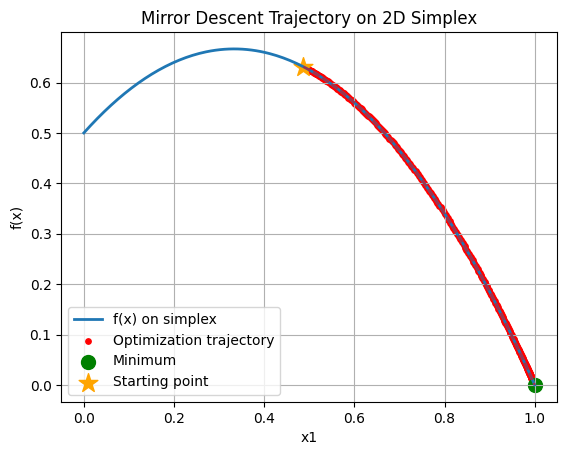

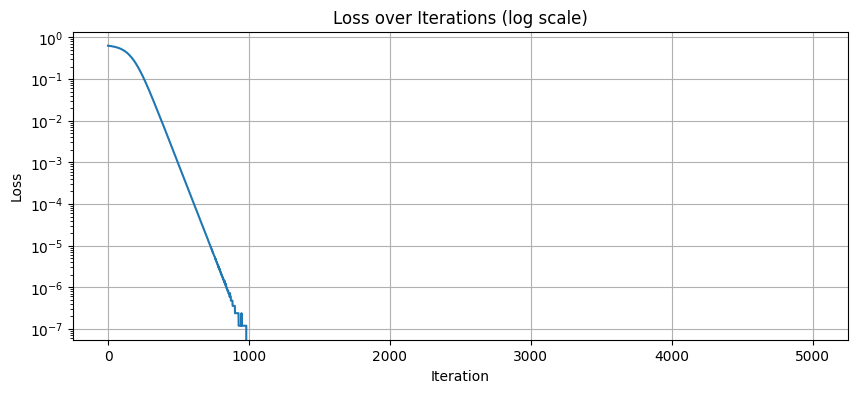

In [2]:
# concave quadratic function
Q = torch.tensor([[-2.0, -1.0],
                  [-1.0, -3.0]])
b = torch.tensor([1.0, 2.0])

def quadratic(x):
    return 0.5 * x @ Q @ x + b @ x

def grad_quadratic(x):
    return Q @ x + b

def stochastic_quadratic(x):
    noise = torch.randn_like(x) * 0.00
    return quadratic(x + noise)

torch.manual_seed(10)
x_init = torch.rand(2)
x_init = x_init / x_init.sum()
trajectory, losses = test_loop(entropic_mirror_map, x_init, quadratic)

t_iters = trajectory[:, 0]

f_iters = []
for x_np in trajectory:
    x_torch = torch.tensor(x_np, dtype=torch.float32)
    f_iters.append(quadratic(x_torch).item())

t_vals = np.linspace(0, 1, 200)
f_vals = []
for t in t_vals:
    x = torch.tensor([t, 1 - t], dtype=torch.float32)
    f_vals.append(quadratic(x).item())

# Plot the function on simplex
plt.plot(t_vals, f_vals, label='f(x) on simplex', linewidth=2)
# Plot the trajectory of iterates
plt.scatter(t_iters, f_iters, color='red', label='Optimization trajectory', s=15)
plt.scatter(t_iters[-1], f_iters[-1], color='green', label='Minimum', s=100)
plt.scatter(x_init[0], quadratic(x_init), color='orange', marker='*', label='Starting point', s=200)
plt.plot(t_iters, f_iters, color='red', linestyle='dashed', alpha=0.6)

plt.xlabel('x1')
plt.ylabel('f(x)')
plt.title('Mirror Descent Trajectory on 2D Simplex')
plt.legend()
plt.grid(True)
plt.show()

# Loss curve
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss over Iterations (log scale)")
plt.grid(True)
plt.show()

Elapsed time: 0.60 seconds
Loss < 1.0 reached at iteration 0
Loss < 0.1 reached at iteration 50
Loss < 0.01 reached at iteration 61
Loss < 0.001 reached at iteration 62
Loss < 0.0001 reached at iteration 62
Loss < 1e-05 reached at iteration 62


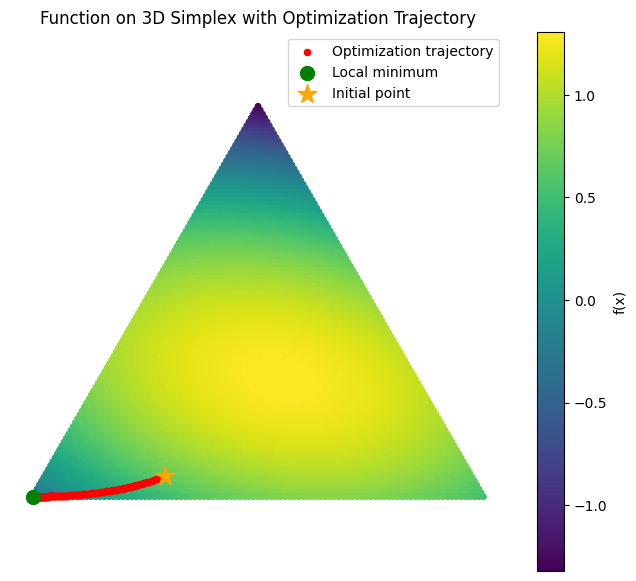

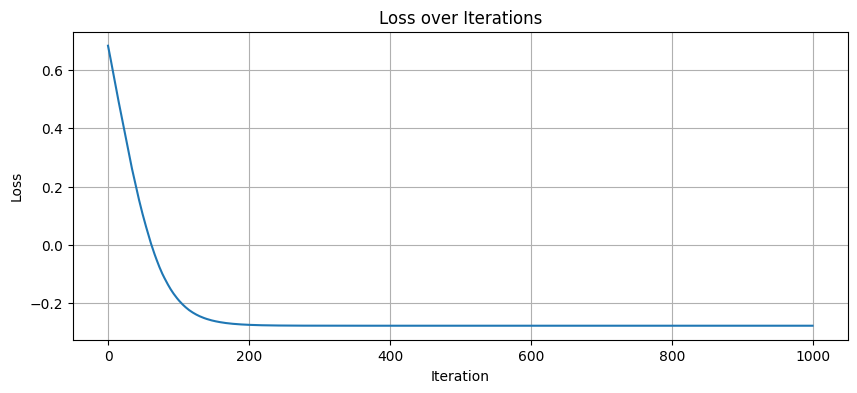

In [4]:
# concave quadratic function
Q = torch.tensor([[-10.0362,  -4.7471,   0.5615],
        [ -4.7471,  -4.6708,   1.4179],
        [  0.5615,   1.4179,  -2.9237]])
b = torch.tensor([4.7412, 2.8671, 0.1415])

def quadratic(x):
    return 0.5 * x @ Q @ x + b @ x

def grad_quadratic(x):
    return Q @ x + b

def stochastic_quadratic(x):
    noise = torch.randn_like(x) * 0.01
    return quadratic(x + noise)

x_init = torch.rand(3)
x_init = x_init / x_init.sum()
trajectory, losses = test_loop(entropic_mirror_map, x_init, quadratic, max_iter=1000)


# Create a fine grid of points in the simplex
n_points = 100
x_list = []
for i in range(n_points+1):
    for j in range(n_points+1 - i):
        k = n_points - i - j
        x1 = i / n_points
        x2 = j / n_points
        x3 = k / n_points
        x_list.append([x1, x2, x3])
x_arr = np.array(x_list)

# Compute function values at those points
f_vals = []
for x_np in x_arr:
    x_t = torch.tensor(x_np, dtype=torch.float32)
    f_vals.append(quadratic(x_t).item())
f_vals = np.array(f_vals)

# Convert barycentric coords to cartesian for plotting
xy = barycentric_to_cartesian(x_arr)

# Plot filled contour (scatter colored by f(x))
plt.figure(figsize=(8,7))
sc = plt.scatter(xy[:,0], xy[:,1], c=f_vals, cmap='viridis', s=15)
plt.colorbar(sc, label='f(x)')

# Plot optimization trajectory (trajectory is array Nx3)
# Convert trajectory points to cartesian and plot
trajectory_xy = barycentric_to_cartesian(trajectory)
trajectory_f = []
for x_np in trajectory:
    x_t = torch.tensor(x_np, dtype=torch.float32)
    trajectory_f.append(quadratic(x_t).item())

plt.scatter(trajectory_xy[:, 0], trajectory_xy[:, 1], c='red', marker='o', s=20, label='Optimization trajectory')
x_init_xy = barycentric_to_cartesian(np.array([x_init.numpy()]))[0]
plt.scatter(trajectory_xy[-1, 0], trajectory_xy[-1, 1], color='green', label='Local minimum', s=100)
plt.scatter(x_init_xy[0], x_init_xy[1], color='orange', marker='*', s=200, label='Initial point')

plt.title('Function on 3D Simplex with Optimization Trajectory')
plt.axis('equal')
plt.axis('off')
plt.legend()
plt.show()

# Loss curve
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss over Iterations")
plt.grid(True)
plt.show()

Elapsed time: 3.09 seconds


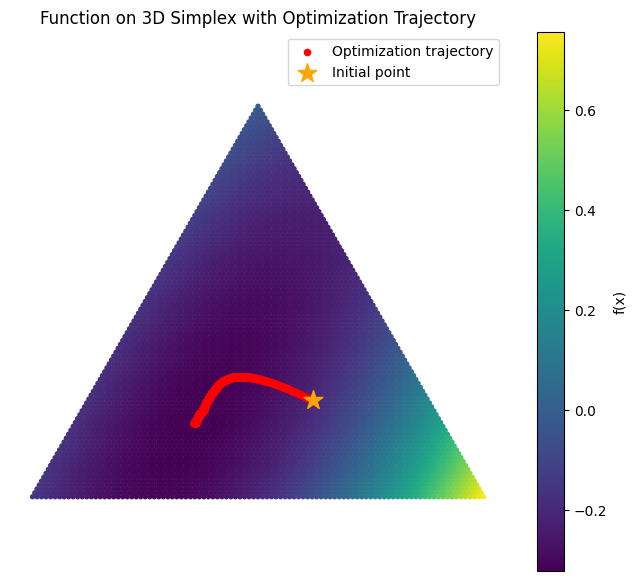

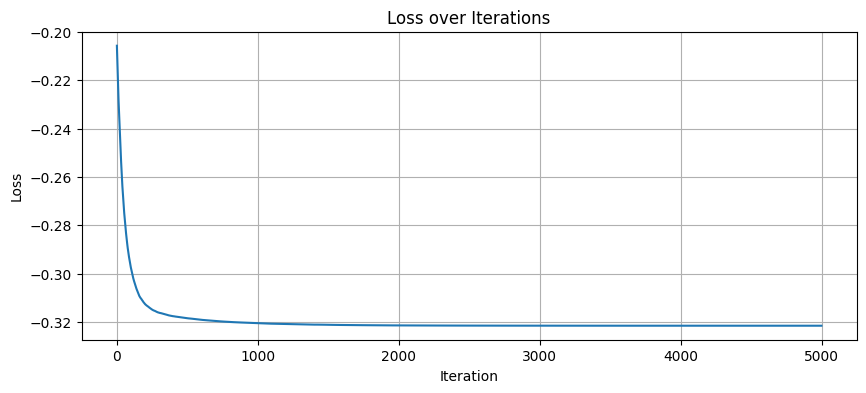

In [5]:
# Q indefinite

Q = torch.tensor([[1.59013784, -0.84236252,  0.60832001],
        [-0.84236252,  0.8312001 , -1.5313728 ],
        [ 0.60832001, -1.5313728 ,  0.28483157]])
b = torch.tensor([-0.94522481,  0.34093502, -0.1653904 ])

def quadratic(x):
    return 0.5 * x @ Q @ x + b @ x

def grad_quadratic(x):
    return Q @ x + b

def stochastic_quadratic(x):
    noise = torch.randn_like(x) * 0.01
    return quadratic(x + noise)

# Optimization variable
# torch.manual_seed(10)
x_init = torch.rand(3)
x_init = x_init / x_init.sum()
trajectory, losses = test_loop(entropic_mirror_map, x_init, quadratic, thresholds=False)

# Create a fine grid of points in the simplex
n_points = 100
x_list = []
for i in range(n_points+1):
    for j in range(n_points+1 - i):
        k = n_points - i - j
        x1 = i / n_points
        x2 = j / n_points
        x3 = k / n_points
        x_list.append([x1, x2, x3])
x_arr = np.array(x_list)

# Compute function values at those points
f_vals = []
for x_np in x_arr:
    x_t = torch.tensor(x_np, dtype=torch.float32)
    f_vals.append(quadratic(x_t).item())
f_vals = np.array(f_vals)

# Convert barycentric coords to cartesian for plotting
xy = barycentric_to_cartesian(x_arr)

# Plot filled contour (scatter colored by f(x))
plt.figure(figsize=(8,7))
sc = plt.scatter(xy[:,0], xy[:,1], c=f_vals, cmap='viridis', s=8)
plt.colorbar(sc, label='f(x)')

# Plot optimization trajectory (trajectory is array Nx3)
# Convert trajectory points to cartesian and plot
trajectory_xy = barycentric_to_cartesian(trajectory)
trajectory_f = []
for x_np in trajectory:
    x_t = torch.tensor(x_np, dtype=torch.float32)
    trajectory_f.append(quadratic(x_t).item())

plt.scatter(trajectory_xy[:, 0], trajectory_xy[:, 1], c='red', marker='o', s=20, label='Optimization trajectory')
x_init_xy = barycentric_to_cartesian(np.array([x_init.numpy()]))[0]
plt.scatter(x_init_xy[0], x_init_xy[1], color='orange', marker='*', s=200, label='Initial point')

plt.title('Function on 3D Simplex with Optimization Trajectory')
plt.axis('equal')
plt.axis('off')
plt.legend()
plt.show()

# Loss curve
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss over Iterations")
plt.grid(True)
plt.show()

Elapsed time: 0.19 seconds
Elapsed time: 0.16 seconds
Argmax (Stochastic): 14
Argmax (Deterministic): 14
Elapsed time: 0.16 seconds
Elapsed time: 0.16 seconds
Argmax (Stochastic): 47
Argmax (Deterministic): 47
Elapsed time: 0.17 seconds
Elapsed time: 0.16 seconds
Argmax (Stochastic): 14
Argmax (Deterministic): 14
Elapsed time: 0.16 seconds
Elapsed time: 0.16 seconds
Argmax (Stochastic): 35
Argmax (Deterministic): 47
Elapsed time: 0.16 seconds
Elapsed time: 0.16 seconds
Argmax (Stochastic): 35
Argmax (Deterministic): 35
Elapsed time: 0.19 seconds
Elapsed time: 0.16 seconds
Argmax (Stochastic): 26
Argmax (Deterministic): 47
Elapsed time: 0.16 seconds
Elapsed time: 0.15 seconds
Argmax (Stochastic): 5
Argmax (Deterministic): 48
Elapsed time: 0.16 seconds
Elapsed time: 0.15 seconds
Argmax (Stochastic): 47
Argmax (Deterministic): 47
Elapsed time: 0.20 seconds
Elapsed time: 0.17 seconds
Argmax (Stochastic): 5
Argmax (Deterministic): 5
Elapsed time: 0.17 seconds
Elapsed time: 0.16 seconds
Argm

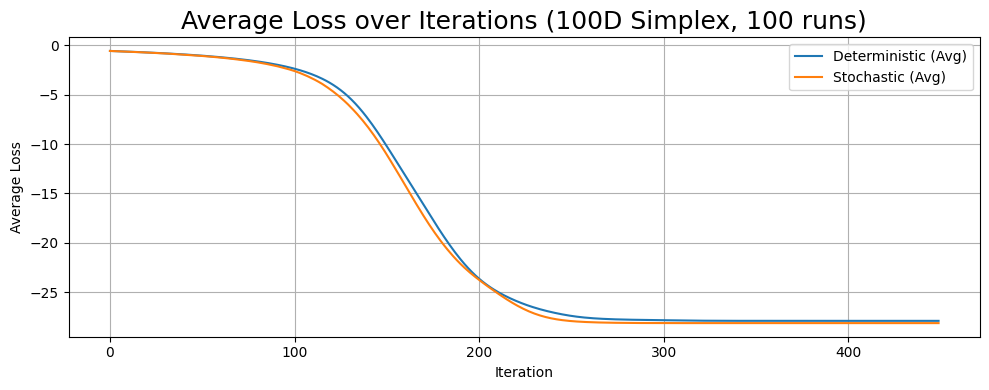

In [11]:
import torch
import matplotlib.pyplot as plt

d = 50
runs = 100
max_iter = 450
lr = 0.003

A = torch.randn(d, d)
Q = -A @ A.T  # Negative definite
b = torch.randn(d)

def quadratic(x):
    return 0.5 * x @ Q @ x + b @ x

def grad_quadratic(x):
    return Q @ x + b

losses_all = torch.zeros(runs, max_iter)
losses_det_all = torch.zeros(runs, max_iter)

for i in range(runs):
    x_init = torch.rand(d)
    x_init = x_init / x_init.sum()

    trajectory, losses = test_loop(entropic_mirror_map, x_init, quadratic, noise_const=0.1, thresholds=False, max_iter=max_iter, lr=lr)
    trajectory_det, losses_det = test_loop(entropic_mirror_map, x_init, quadratic, noise_const=0, thresholds=False, max_iter=max_iter, lr=lr)
    final_x_stochastic = torch.tensor(trajectory[-1])
    final_x_deterministic = torch.tensor(trajectory_det[-1])

    print("Argmax (Stochastic):", torch.argmax(final_x_stochastic).item())
    print("Argmax (Deterministic):", torch.argmax(final_x_deterministic).item())

    losses_all[i] = torch.tensor(losses)
    losses_det_all[i] = torch.tensor(losses_det)

# Average across runs
avg_losses = losses_all.mean(dim=0)
avg_losses_det = losses_det_all.mean(dim=0)

# --- Plot Average Loss Curve ---
plt.figure(figsize=(10, 4))
plt.plot(avg_losses_det, label="Deterministic (Avg)")
plt.plot(avg_losses, label="Stochastic (Avg)")
plt.xlabel("Iteration")
plt.ylabel("Average Loss")
plt.title("Average Loss over Iterations (100D Simplex, 100 runs)", fontsize=18)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Elapsed time: 0.61 seconds
Loss < 1.0 reached at iteration 43
Loss < 0.1 reached at iteration 72
Loss < 0.01 reached at iteration 74
Loss < 0.001 reached at iteration 75
Loss < 0.0001 reached at iteration 75
Loss < 1e-05 reached at iteration 75


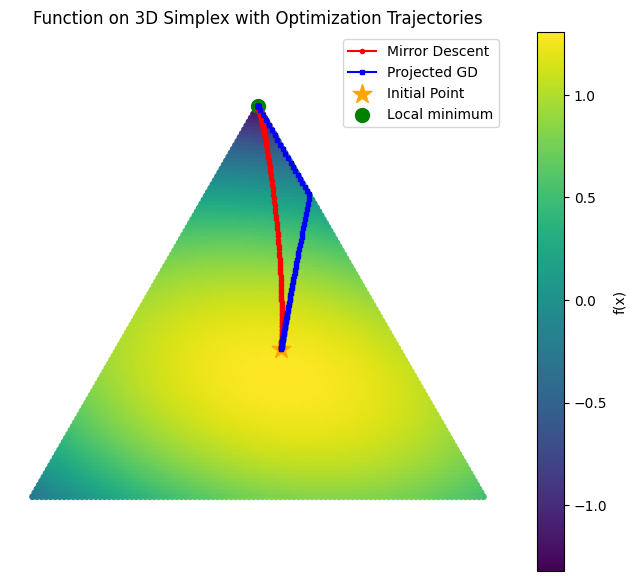

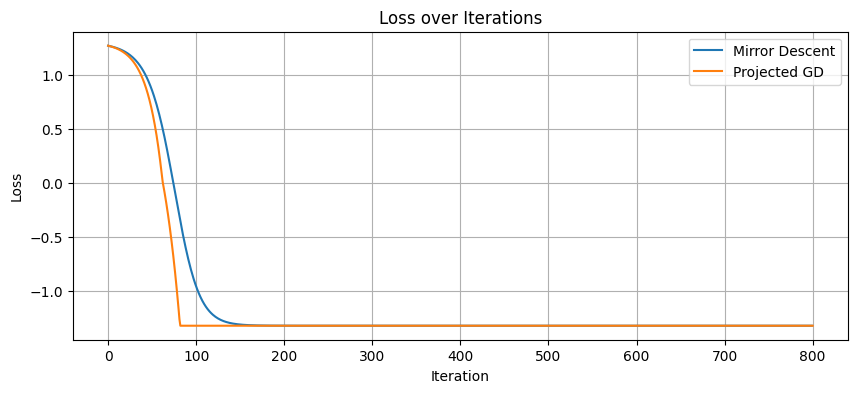

In [104]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Concave quadratic function
Q = torch.tensor([[-10.0362,  -4.7471,   0.5615],
                  [ -4.7471,  -4.6708,   1.4179],
                  [  0.5615,   1.4179,  -2.9237]])
b = torch.tensor([4.7412, 2.8671, 0.1415])

def quadratic(x):
    return 0.5 * x @ Q @ x + b @ x

def grad_quadratic(x):
    return Q @ x + b

# Project onto simplex
def project_to_simplex(v):
    sorted_v, _ = torch.sort(v, descending=True)
    tmp_sum = 0.0
    rho = -1
    for j in range(len(v)):
        tmp_sum += sorted_v[j]
        t = (tmp_sum - 1) / (j + 1)
        if sorted_v[j] > t:
            rho = j
    theta = (sorted_v[:rho+1].sum() - 1) / (rho + 1)
    return torch.clamp(v - theta, min=0.0)

# Projected Gradient Descent
def projected_gradient_descent(x0, grad_fn, step_size=0.01, max_iter=1000):
    x = x0.clone()
    trajectory = [x.clone().numpy()]
    losses = [quadratic(x).item()]
    
    for _ in range(max_iter):
        grad = grad_fn(x)
        x = x - step_size * grad
        x = project_to_simplex(x)
        trajectory.append(x.clone().numpy())
        losses.append(quadratic(x).item())
    
    return np.array(trajectory), losses

# Generate simplex grid for plotting the function
n_points = 100
x_list = []
for i in range(n_points+1):
    for j in range(n_points+1 - i):
        k = n_points - i - j
        x1 = i / n_points
        x2 = j / n_points
        x3 = k / n_points
        x_list.append([x1, x2, x3])
x_arr = np.array(x_list)

f_vals = []
for x_np in x_arr:
    x_t = torch.tensor(x_np, dtype=torch.float32)
    f_vals.append(quadratic(x_t).item())
f_vals = np.array(f_vals)
xy = barycentric_to_cartesian(x_arr)

# Run both algorithms
x_init = torch.rand(3)
x_init = x_init / x_init.sum()

trajectory_md, losses_md = test_loop(entropic_mirror_map, x_init, quadratic, noise_const=0, lr=0.01, max_iter=800)
trajectory_gd, losses_gd = projected_gradient_descent(x_init, grad_quadratic, step_size=0.004, max_iter=800)

# Plot contour and both trajectories
plt.figure(figsize=(8,7))
sc = plt.scatter(xy[:,0], xy[:,1], c=f_vals, cmap='viridis', s=15)
plt.colorbar(sc, label='f(x)')

trajectory_md_xy = barycentric_to_cartesian(trajectory_md)
trajectory_gd_xy = barycentric_to_cartesian(trajectory_gd)
x_init_xy = barycentric_to_cartesian(np.array([x_init.numpy()]))[0]

# Plot trajectories
plt.plot(trajectory_md_xy[:, 0], trajectory_md_xy[:, 1], 'r-o', markersize=3, label='Mirror Descent')
plt.plot(trajectory_gd_xy[:, 0], trajectory_gd_xy[:, 1], 'b-s', markersize=3, label='Projected GD')
plt.scatter(x_init_xy[0], x_init_xy[1], color='orange', marker='*', s=200, label='Initial Point')
plt.scatter(trajectory_md_xy[-1, 0], trajectory_md_xy[-1, 1], color='green', s=100, label='Local minimum')

plt.title('Function on 3D Simplex with Optimization Trajectories')
plt.axis('equal')
plt.axis('off')
plt.legend()
plt.show()

# Plot loss curves
plt.figure(figsize=(10, 4))
plt.plot(losses_md, label='Mirror Descent')
plt.plot(losses_gd, label='Projected GD')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss over Iterations")
plt.legend()
plt.grid(True)
plt.show()
